In [1]:
import pandas as pd

In [25]:
# from Baseball Savant, get weighted zone contact % using TY and LY data
# min pa = 50
def read_zone_contact(year):
    df = pd.read_csv(f'Zone Contact {year - 1}-{year}.csv', index_col=False).drop('Unnamed: 7', axis=1)
        
    # for LY data, give it half-weight
    df.loc[df['year'] < year, 'in_zone_swing'] /= 2
    
    # calculate the weighted launch angle
    df['in_zone_contact'] = df['in_zone_swing'] * df['iz_contact_percent']
    df_grouped = df.groupby(['player_id']).sum()
    df_grouped['iz_contact_percent'] = df_grouped['in_zone_contact'] / df_grouped['in_zone_swing']
    df_grouped = df_grouped[df_grouped['year'] >= year]
    
    # join with player ids
    player_map = pd.read_csv('../PLAYERIDMAP 2022.csv')[['MLBID', 'PLAYERNAME']].set_index('MLBID')
    merge = df_grouped[['iz_contact_percent']].merge(player_map, how='left', left_index=True, right_index=True)[['PLAYERNAME', 'iz_contact_percent']]
    
    mean = merge['iz_contact_percent'].mean()
    std = merge['iz_contact_percent'].std()
    
    merge['Z'] = (merge['iz_contact_percent'] - mean) / std
    
    return merge

zc_data = read_zone_contact(2022)
zc_data.head()

,PLAYERNAME,iz_contact_percent,Z
405395,Albert Pujols,88.206873,1.244393
408234,Miguel Cabrera,81.101449,-0.011030
425877,Yadier Molina,81.766908,0.106547
429664,Robinson Cano,87.200000,1.066494
435559,Kurt Suzuki,86.663411,0.971687


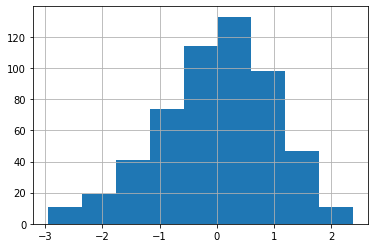

In [71]:
# CONVERSIONS:
# 3-11
contact_zc_conversion = {
    4: -2.3,
    5: -1.7,
    6: -1.1,
    7: -0.5,
    8: 0.1,
    9: 0.7,
    10: 1.3,
    11: 1.9,
}
hist = zc_data['Z'].hist(bins=9)

In [74]:
def get_con(zc):
    current_con = 3
    while current_con < 11:
        floor = contact_zc_conversion[current_con + 1]
        if zc > floor:
            current_con += 1
        else:
            break
    return current_con

In [77]:
def assign_con(year):
    zc_data = read_zone_contact(2022)
    zc_data['Contact'] = zc_data.apply(lambda x: get_con(x['Z']), axis=1)
    return zc_data[['PLAYERNAME', 'Contact']].dropna()

con_df = assign_con(2022)
con_df.head()

,PLAYERNAME,Contact
405395,Albert Pujols,9
408234,Miguel Cabrera,7
425877,Yadier Molina,8
429664,Robinson Cano,9
435559,Kurt Suzuki,9


In [78]:
con_df.to_csv('2022_Contact.csv')